In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd 
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
import xarray as xr
import cmocean.cm as cm

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [5]:
# define the input directory
input_dir = os.getcwd()

### Step 2: Read in the Model grid

To read in the model fields, I will rely on the grid parameters from the grid file:

In [6]:
# define the parameters that will be used in the data file
x_min, x_max = -121.795, -121.739
y_min, y_max =  36.80,    36.861

delX = 0.00015556
delY = 0.00025417
xgOrigin = -121.795
ygOrigin = 36.8
n_rows = 240
n_cols = 360

# recreate the grids that will be used in the model
xc = np.arange(x_min + delX/2, x_max + delX/2, delX)  # lon centers
yc = np.arange(y_min + delY/2, y_max + delY/2, delY)  # lat centers
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'slough_bathymetry.bin'),'>f4').reshape(np.shape(XC))

bathy.shape
# If your bathy is negative in the ocean and >=0 on land:
bathy_pd = np.maximum(0.0, -bathy)   # positive-down depth; land becomes 0


With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [7]:
delR = np.array([1, 2, 3, 4, 5])  # 5 layers (total 15 m depth)

In [8]:
def create_hFacC_grid(bathy_pd, delR):
    """
    bathy_pd: 2D array, POSITIVE-DOWN ocean depth (meters). Land = 0.
    delR:     1D array of layer thicknesses (surface to bottom)
    """
    ny, nx = bathy_pd.shape
    nz = len(delR)
    hFacC = np.zeros((nz, ny, nx), dtype=float)

    z_edges = np.concatenate(([0.0], np.cumsum(delR)))   # layer interfaces
    for k in range(nz):
        z_top, z_bot = z_edges[k], z_edges[k+1]
        full    = bathy_pd >= z_bot
        partial = (bathy_pd >  z_top) & (bathy_pd <  z_bot)

        hFacC[k, full]    = 1.0
        hFacC[k, partial] = (bathy_pd[partial] - z_top) / (z_bot - z_top)

    return hFacC

# Recompute with positive-down depths
hFacC = create_hFacC_grid(bathy_pd, delR)

# Surface-water mask (k=0): 1 if the top cell is wet at all
mask_surface = (hFacC[0] > 0).astype(np.int8)

# Or, "any layer is wet" mask (for plotting coastline-ish land/sea)
mask_any = (hFacC.max(axis=0) > 0).astype(np.int8)

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

C:\Users\rilee\miniconda3\envs\ms274\Lib\site-packages\matplotlib\colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


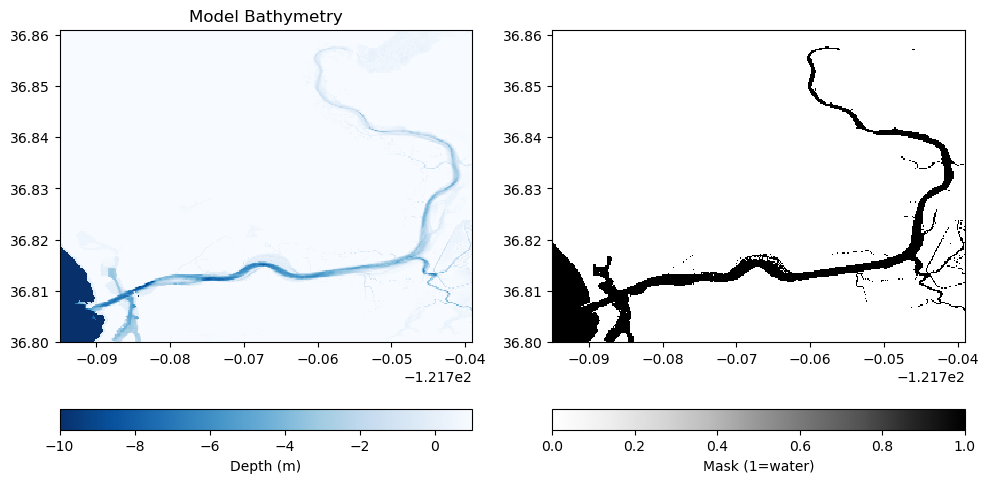

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-10, vmax=1, cmap='Blues_r')
plt.colorbar(C, orientation='horizontal', label='Depth (m)')
plt.title('Model Bathymetry')


plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask_surface, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation='horizontal', label='Mask (1=water)')
#plt.title(f'Mask (depth level = {depth_level})')

plt.tight_layout()
plt.show()


Now let's read in the wind speed data and other external forcing fields

##### Step 4: Read in External Forcing Fields (ATEMP, AQH, PRECIP, TOTPAR, TOTSORAD)

In [10]:
exf_vars = pd.read_csv('slough_exf_vars.csv', header=0, parse_dates = ['DateTimeStamp'], index_col = 2, dtype={4: str, 6: str})
exf_vars.columns.tolist()

['StationCode',
 'isSWMP',
 'F_Record',
 'ATemp',
 'F_ATemp',
 'RH',
 'F_RH',
 'BP',
 'F_BP',
 'TotPAR',
 'F_TotPAR',
 'TotPrcp',
 'F_TotPrcp',
 'TotSoRad',
 'F_TotSoRad']

In [11]:
var_list = ['ATemp', 'RH', 'TotPAR', 'TotPrcp', 'TotSoRad']
daily_means = pd.DataFrame()

for var in var_list:
    # Convert to numeric
    exf_vars[var] = pd.to_numeric(exf_vars[var], errors='coerce')
    
    # Resample daily and store in new DataFrame
    daily_means[var] = exf_vars[var].resample('D').mean()

In [34]:
daily_means

,ATemp,RH,TotPAR,TotPrcp,TotSoRad
DateTimeStamp,,,,,
2024-10-01,19.905208,63.468750,383.668750,0.000000,NaN
2024-10-02,18.937500,73.156250,384.908333,0.000000,NaN
2024-10-03,18.888542,70.239583,390.877083,0.000000,NaN
2024-10-04,15.941667,86.416667,346.040625,0.000000,NaN
2024-10-05,16.054167,88.052083,381.164583,0.000000,NaN
...,...,...,...,...,...
2025-09-27,16.652083,90.406250,81.615625,0.000000,NaN
2025-09-28,18.414583,87.000000,257.241667,0.006250,NaN
2025-09-29,17.963542,86.583333,196.759375,0.000000,NaN


##### Read in Wind Data

In [12]:
df = pd.read_csv(
        "slough_wind.csv", parse_dates=['DateTimeStamp'])
df['DateTimeStamp'] = pd.to_datetime(df['DateTimeStamp'])
df = df.set_index('DateTimeStamp')
print(df.tail())

                    StationCode isSWMP  WSpd F_WSpd  Wdir F_Wdir
DateTimeStamp                                                   
2025-10-01 23:45:00  elkvmwq         P   NaN    NaN   NaN    NaN
2025-10-01 23:45:00  elksmwq         P   NaN    NaN   NaN    NaN
2025-10-01 23:45:00  elknmwq         P   NaN    NaN   NaN    NaN
2025-10-01 23:45:00  elkcwmet        P   1.3   <0>   77.0   <0> 
2025-10-01 23:45:00  elkapwq         P   NaN    NaN   NaN    NaN


In [46]:
ws_daily = df['WSpd'].resample('D').mean()
print(ws_daily)

DateTimeStamp
2024-10-01    1.313542
2024-10-02    1.233333
2024-10-03    1.285417
2024-10-04    1.594792
2024-10-05    1.363542
                ...   
2025-09-27    2.219792
2025-09-28    2.648958
2025-09-29    1.957292
2025-09-30    2.620833
2025-10-01    1.677320
Freq: D, Name: WSpd, Length: 366, dtype: float64


In [55]:
#get u and v components 
theta = np.deg2rad(df['Wdir'])
df['u'] = -df['WSpd'] * np.sin(theta)
df['v'] = -df['WSpd'] * np.cos(theta)


#resample U and V components
u_daily = df['u'].resample('D').mean()
v_daily = df['v'].resample('D').mean()

#### Interpolate and make EXF Grids!

In [30]:
#interpolate all variables (except wind)
ntime = len(daily_means)
year = daily_means.index[0].year
nrows, ncols = XC.shape  # grid shape

for var in var_list:
    print(f"Generating EXF field for {var} with {ntime} timesteps")

    data = daily_means[var].values.astype(float)

    # Allocate EXF grid
    interpolated_grid = np.zeros((ntime, nrows, ncols), dtype='float32')

    for t in range(ntime):
        interpolated_grid[t,:,:] = data[t] * mask_surface
        
    if var =='ATemp':
        interpolated_grid[interpolated_grid!=0] += 273.15
    # Output filename
    output_file = os.path.join(input_dir, 'exf', f"{var}_{year}")
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    print("Saved:", output_file)

Generating EXF field for ATemp with 366 timesteps
Saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\ATemp_2024
Generating EXF field for RH with 366 timesteps
Saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\RH_2024
Generating EXF field for TotPAR with 366 timesteps
Saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\TotPAR_2024
Generating EXF field for TotPrcp with 366 timesteps
Saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\TotPrcp_2024
Generating EXF field for TotSoRad with 366 timesteps
Saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\TotSoRad_2024


In [56]:
ws = ws_daily.values.astype(float)
u = u_daily.values.astype(float)
v = u_daily.values.astype(float)

ntime = len(ws)
# Extract year automatically
year = ws_daily.index[0].year
# Model grid size
nrows, ncols = XC.shape

# Build uniform wind speed forcing
interpolated_ws = np.zeros((ntime, nrows, ncols), dtype='float32')
interpolated_u = np.zeros((ntime, nrows, ncols), dtype='float32')
interpolated_v = np.zeros((ntime, nrows, ncols), dtype='float32')

for t in range(ntime):
    interpolated_ws[t,:,:] = ws[t] * mask_surface
    interpolated_u[t,:,:]  = u[t] * mask_surface
    interpolated_v[t,:,:]  = v[t] * mask_surface

# --- Save EXF files ---
output_dir = os.path.join(input_dir, 'exf')

# Save EXF
# WDSPD
ws_file = os.path.join(output_dir, f"WDSPD_{year}")
interpolated_ws.ravel('C').astype('>f4').tofile(ws_file)
print("WDSPD EXF forcing saved:", ws_file)

# UWIND
u_file = os.path.join(output_dir, f"UWIND_{year}")
interpolated_u.ravel('C').astype('>f4').tofile(u_file)
print("UWIND EXF forcing saved:", u_file)

# VWIND
v_file = os.path.join(output_dir, f"VWIND_{year}")
interpolated_v.ravel('C').astype('>f4').tofile(v_file)
print("VWIND EXF forcing saved:", v_file)

WDSPD EXF forcing saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\WDSPD_2024
UWIND EXF forcing saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\UWIND_2024
VWIND EXF forcing saved: C:\Users\rilee\MS 274\Lectures\Week 9\exf\VWIND_2024


#### Plot the External Forcing Fields

In [40]:
#make meta data
meta_dict = {'ATemp':[273, 290, cm.thermal, r'$^{\circ}$C'],
             'RH':[0, 0.025, cm.tempo, 'kg/kg'],
             'TotPAR':[-10,400,cm.solar,'W/m$^2$'],
             'TotPrcp':[0, 1e-6, cm.tempo, 'm/s'],
             'TotSoRad':[-10,400,cm.solar,'W/m$^2$']}

In [36]:
data = np.fromfile(os.path.join(input_dir, 'exf', 'UWIND_2024'), '>f4')
n = data.size
print(n, n / (240*360))


31622400 366.0


In [37]:
print("mask_surface unique values:", np.unique(mask_surface))

mask_surface unique values: [0 1]


In [38]:
print("wind shape:", wind_exf_grid.shape)
print("mask shape:", mask_surface.shape)
print("XC shape:", XC.shape)
print("YC shape:", YC.shape)

wind shape: (240, 360)
mask shape: (240, 360)
XC shape: (240, 360)
YC shape: (240, 360)


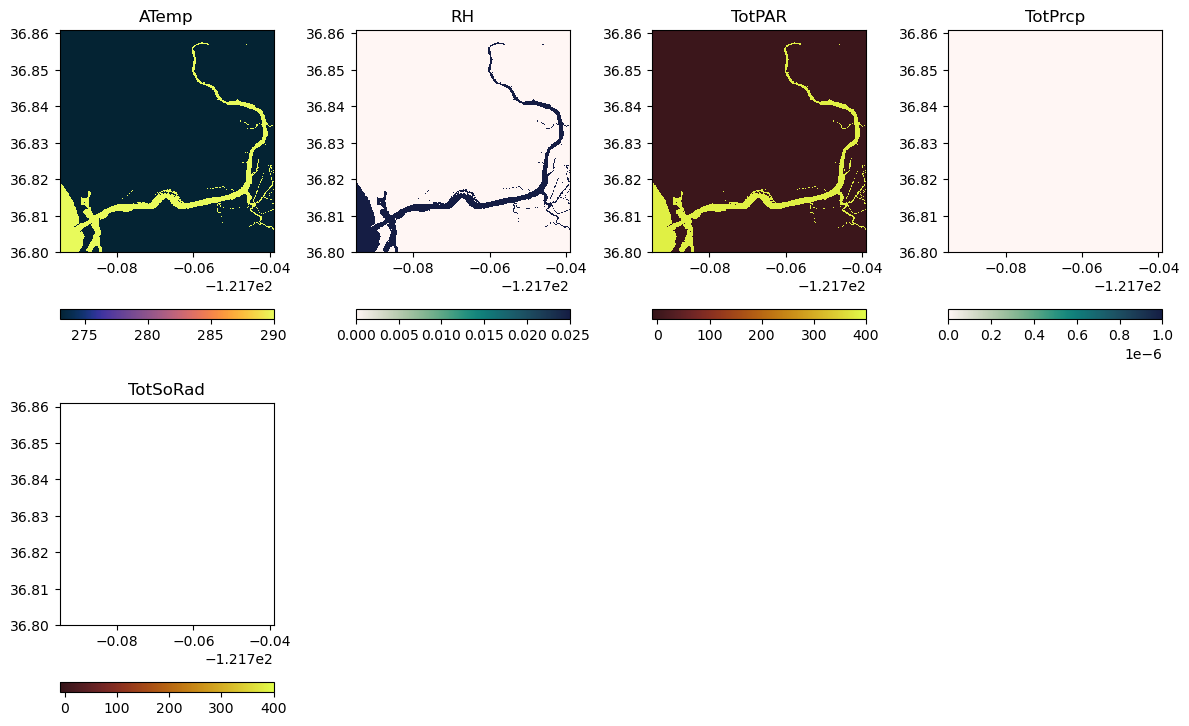

In [41]:
fig = plt.figure(figsize=(12,8))

timestep = 0

for i in range(len(var_list)):
    variable_name = var_list[i]
    
    elk_exf_grid = np.fromfile(os.path.join(input_dir,'exf',variable_name+'_'+str(year)),'>f4')
    elk_exf_grid = elk_exf_grid.reshape((n_timesteps, np.shape(XC)[0], np.shape(YC)[1]))
    elk_exf_grid = elk_exf_grid[timestep, :, :] # choose th
    
    plt.subplot(2,4,i+1)
    C = plt.pcolormesh(XC, YC, elk_exf_grid,
                       vmin=meta_dict[var_list[i]][0],
                       vmax=meta_dict[var_list[i]][1],
                       cmap=meta_dict[var_list[i]][2])
    plt.colorbar(C, fraction=0.26, orientation='horizontal')

    plt.title(variable_name)

plt.tight_layout()

plt.show()

In [70]:
ws_daily

DateTimeStamp
2024-10-01    1.313542
2024-10-02    1.233333
2024-10-03    1.285417
2024-10-04    1.594792
2024-10-05    1.363542
                ...   
2025-09-27    2.219792
2025-09-28    2.648958
2025-09-29    1.957292
2025-09-30    2.620833
2025-10-01    1.677320
Freq: D, Name: WSpd, Length: 366, dtype: float64

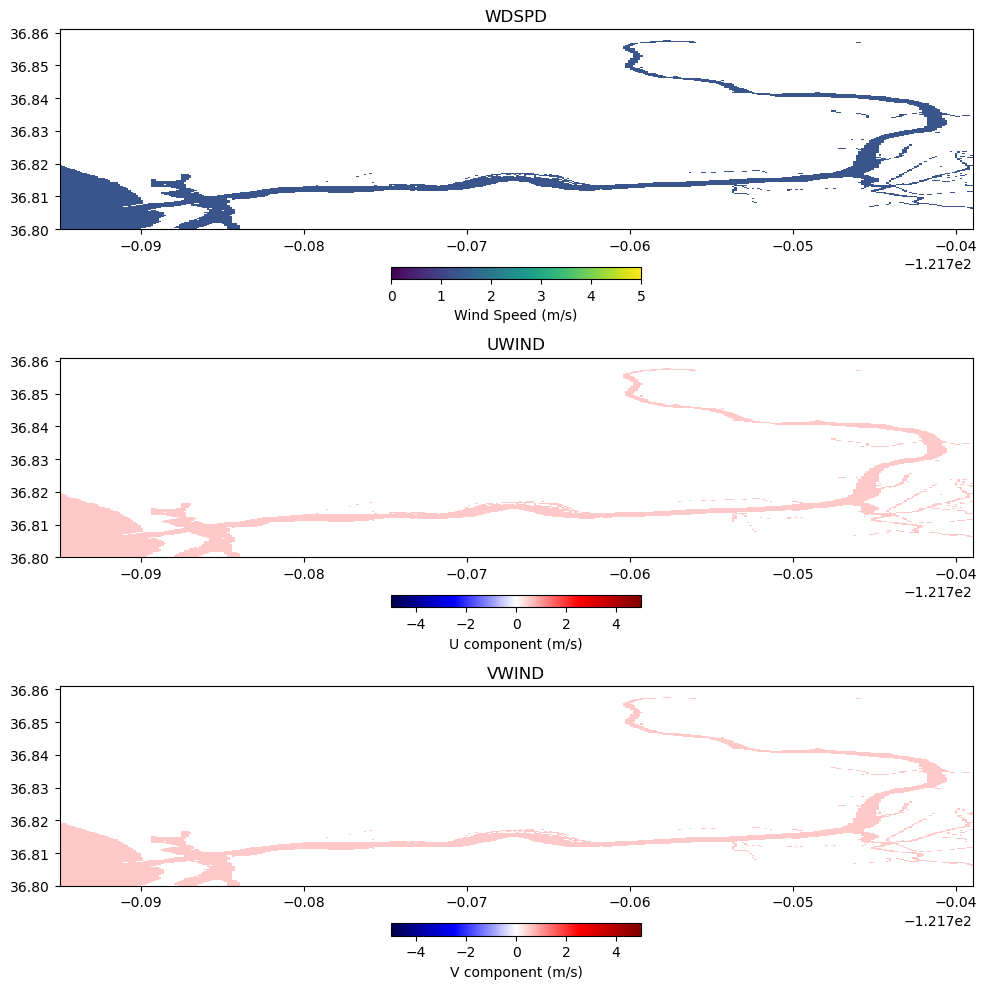

In [72]:
# --- Parameters ---
timestep = 0
n_timesteps = 366

# --- Load EXF files ---
wdspd_file = os.path.join(input_dir, 'exf', 'WDSPD_2024')
uwind_file = os.path.join(input_dir, 'exf', 'UWIND_2024')
vwind_file = os.path.join(input_dir, 'exf', 'VWIND_2024')

wdspd_grid = np.fromfile(wdspd_file, '>f4').reshape((n_timesteps, XC.shape[0], YC.shape[1]))[timestep,:,:]
uwind_grid = np.fromfile(uwind_file, '>f4').reshape((n_timesteps, XC.shape[0], YC.shape[1]))[timestep,:,:]
vwind_grid = np.fromfile(vwind_file, '>f4').reshape((n_timesteps, XC.shape[0], YC.shape[1]))[timestep,:,:]

# --- Apply land mask ---
mask2d = mask_surface
wdspd_masked = np.where(mask2d == 1, wdspd_grid, np.nan)
uwind_masked = np.where(mask2d == 1, uwind_grid, np.nan)
vwind_masked = np.where(mask2d == 1, vwind_grid, np.nan)

# --- Plotting ---
plt.figure(figsize=(10,10))

# WDSPD
plt.subplot(3,1,1)
C1 = plt.pcolormesh(XC, YC, wdspd_masked, cmap='viridis', vmin=0, vmax=5)
plt.colorbar(C1, orientation='horizontal', fraction=0.05, label='Wind Speed (m/s)')
plt.title("WDSPD")

# UWIND
plt.subplot(3,1,2)
C2 = plt.pcolormesh(XC, YC, uwind_masked, cmap='seismic', vmin=-5, vmax=5)
plt.colorbar(C2, orientation='horizontal', fraction=0.05, label='U component (m/s)')
plt.title("UWIND")

# VWIND
plt.subplot(3,1,3)
C3 = plt.pcolormesh(XC, YC, vwind_masked, cmap='seismic', vmin=-5, vmax=5)
plt.colorbar(C3, orientation='horizontal', fraction=0.05, label='V component (m/s)')
plt.title("VWIND")

plt.tight_layout()
plt.show()
